#### Forecasting Amtrak Ridership using ARIMA model
##### 03-31-2024

dataset source: https://www.kaggle.com/datasets/nirmalnk/amtrak-timeseries

In [8]:
# Import packages
import os
import numpy as np 
import pandas as pd
from pandas import to_datetime 
from matplotlib import pyplot as plt 
import seaborn as sns 
import itertools 
import datetime 
from datetime import datetime 
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

# Import ARIMA model packages 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt 

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression 
from sklearn import linear_model 

# Import Auto ARIMA packages
import pmdarima as pm 
from pmdarima.model_selection import train_test_split


In [3]:
# Import database 
df = pd.read_csv("AmtrakBig_raw.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Month      159 non-null    object
 1   Ridership  159 non-null    int64 
 2   t          159 non-null    int64 
 3   Season     159 non-null    object
dtypes: int64(2), object(2)
memory usage: 5.1+ KB


In [4]:
df.head()

,Month,Ridership,t,Season
0,Jan-91,1709,1,Jan
1,Feb-91,1621,2,Feb
2,Mar-91,1973,3,Mar
3,Apr-91,1812,4,Apr
4,May-91,1975,5,May


##### 1. Data Preparation

In [5]:
# Select t, Ridership only 
df2 = df[['Month', 'Ridership']]

# Convert Month to datetime format 
df2['Month'] = pd.to_datetime(df2['Month'], format='%b-%y')

df2.info()
df2.head(10) #Now we have list of monthly rent from 2015-01 to 2024-02.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Month      159 non-null    datetime64[ns]
 1   Ridership  159 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.6 KB


,Month,Ridership
0,1991-01-01,1709
1,1991-02-01,1621
2,1991-03-01,1973
3,1991-04-01,1812
4,1991-05-01,1975
5,1991-06-01,1862
6,1991-07-01,1940
7,1991-08-01,2013
8,1991-09-01,1596
9,1991-10-01,1725


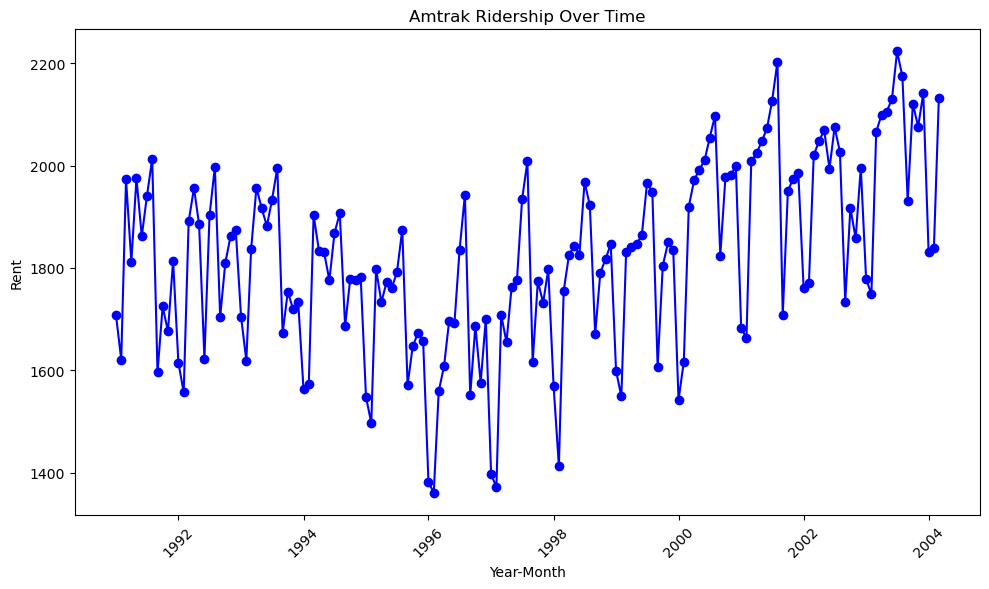

In [6]:
# Plot a line plot using the time series dataset
plt.figure(figsize=(10, 6))  # Set the figure size 
plt.plot(df2['Month'], df2['Ridership'], marker='o', linestyle='-', color='b')  # Plot with markers and a line

plt.title('Amtrak Ridership Over Time')  
plt.xlabel('Year-Month')  
plt.ylabel('Rent')  
plt.xticks(rotation=45)  
plt.tight_layout()

plt.show()  

There are visible patterns that suggest seasonality in the data → Try Seasonal ARIMA here

##### 2. Fit SARIMA model for forecasting

In [8]:
train = df[:-12]
validation = df[-12:]

# Find the best p,d,q combination gives lowest AIC
p = d = q = range(0, 3)  # ranges for ARIMA parameters, 0 - 2
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] # 12 for 12 months

best_aic = float("inf")
best_params = None
best_seasonal_params = None

for param in itertools.product(p, d, q):
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(train['Ridership'],
                            order=param,
                            seasonal_order=seasonal_param,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(maxiter=200, disp=0)  # Set disp=0 to reduce output verbosity
        except Exception as e:
            print(f"ARIMA{param}x{seasonal_param} - AIC: None - Exception: {e}")
            continue  # Continue to the next iteration

        # Check if the current model AIC is lower than what we've seen before
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
            best_seasonal_params = seasonal_param

# Print out the best parameters and AIC
if best_params is not None:
    print(f"Best SARIMA parameters: {best_params}")
    print(f"Best Seasonal parameters: {best_seasonal_params}")
    print(f"Best AIC: {best_aic}")
else:
    print("No suitable model was found.")


Best SARIMA parameters: (0, 2, 2)
Best Seasonal parameters: (0, 2, 2, 12)
Best AIC: 1070.9745724402078


In [10]:
# Fit the model with the best parameters

best_model = SARIMAX(df['Ridership'],
                     order=best_params,
                     seasonal_order=best_seasonal_params,
                     enforce_stationarity=False,
                     enforce_invertibility=False)
best_model_fit = best_model.fit()

# Summarize the final model
print(best_model_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.00841D+00    |proj g|=  1.78486D-01


 This problem is unconstrained.



At iterate    5    f=  3.98794D+00    |proj g|=  4.96291D-02

At iterate   10    f=  3.97932D+00    |proj g|=  4.92513D-03

At iterate   15    f=  3.97902D+00    |proj g|=  5.77569D-03

At iterate   20    f=  3.97466D+00    |proj g|=  9.10694D-02

At iterate   25    f=  3.82404D+00    |proj g|=  2.63366D-01

At iterate   30    f=  3.73774D+00    |proj g|=  1.44501D-01

At iterate   35    f=  3.73117D+00    |proj g|=  1.02252D-03

At iterate   40    f=  3.73116D+00    |proj g|=  6.12367D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     51      1     0     0   1.076D-05   3.731D+00
  F =   3.73116062394

In [15]:
# Generate forecasts for the validation period
forecast_result = best_model_fit.get_forecast(steps=12)

# Get the forecast values
forecasted_values = forecast_result.predicted_mean

# Get the confidence intervals of the forecasts
conf_int = forecast_result.conf_int(alpha=0.05)
print(conf_int)

     lower Ridership  upper Ridership
159      2063.211779      2299.028606
160      2048.702934      2328.347604
161      2057.279887      2376.617084
162      2110.463105      2466.744506
163      2053.407706      2444.664061
164      1742.461795      2167.210591
165      1935.122771      2392.207502
166      1888.239679      2376.733679
167      1937.649693      2456.794252
168      1632.195507      2181.354119
169      1624.402016      2202.407449
170      1902.668678      2510.738722


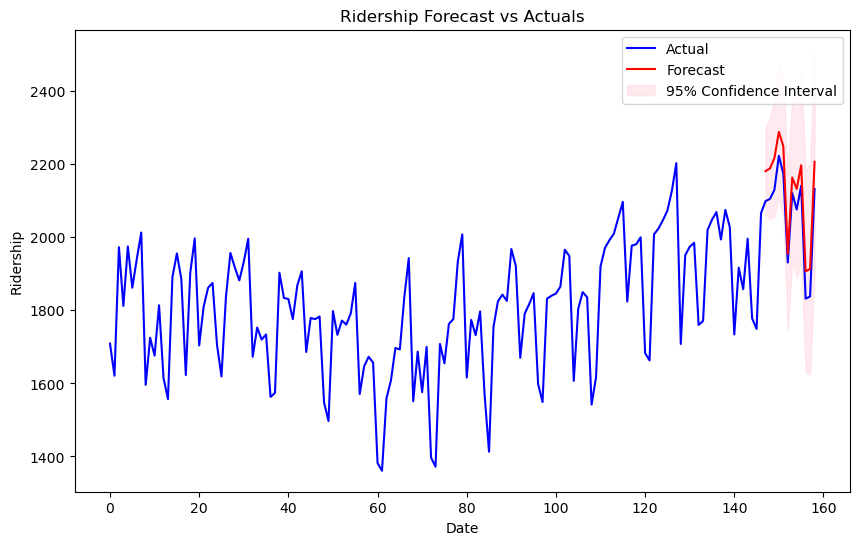

In [16]:
# Visualize the forecasted values vs. actial values 

# Plot the actual data
plt.figure(figsize=(10, 6))
plt.plot(df['Ridership'], label='Actual', color='blue')

# Plot the forecasted values
plt.plot(validation.index, forecasted_values, label='Forecast', color='red')

# Plot the confidence interval as a shaded area around the line
plt.fill_between(validation.index,
                 conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('Ridership Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.legend()
plt.show()


In [19]:
# Calculate MAE and RMSE and for quantitative evaluation and display
mae = mean_absolute_error(validation['Ridership'], forecasted_values)
rmse = np.sqrt(mean_squared_error(validation['Ridership'], forecasted_values))

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

Mean Absolute Error: 66.44390526719188
Root Mean Squared Error: 68.80673485805666


The forecast appears to capture some of the variability in the ridership data

##### 3. ARIMA model

In [10]:
train = df[:-12]
validation = df[-12:]

# Find the best p, d, q combination for the lowest AIC
p = d = q = range(0, 3)  # ranges for ARIMA parameters, 0 - 2

best_aic = float("inf")
best_params = None

for param in itertools.product(p, d, q):
    try:
        # ARIMA model does not use seasonal_order, so we exclude it
        model = ARIMA(train['Ridership'], order=param)
        results = model.fit()  
        
        # Check if the current model AIC is lower than what we've seen before
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
            
    except Exception as e:
        print(f"ARIMA{param} - AIC: None - Exception: {e}")
        continue  # Continue to the next iteration

# Print out the best parameters and AIC
if best_params is not None:
    print(f"Best ARIMA parameters: {best_params}")
    print(f"Best AIC: {best_aic}")
else:
    print("No suitable ARIMA model was found.")


Best ARIMA parameters: (2, 1, 2)
Best AIC: 1843.7717475999127


In [11]:
# Fit the model with the best parameters

best_model = ARIMA(df['Ridership'],
                     order=best_params)
best_model_fit = best_model.fit()

# Summarize the final model
print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Ridership   No. Observations:                  159
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -991.434
Date:                Sun, 31 Mar 2024   AIC                           1992.869
Time:                        22:12:58   BIC                           2008.182
Sample:                             0   HQIC                          1999.088
                                - 159                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0046      0.009     -0.506      0.613      -0.022       0.013
ar.L2         -0.9922      0.008   -130.587      0.000      -1.007      -0.977
ma.L1         -0.1063      0.031     -3.425      0.0

In [12]:
# Generate forecasts for the validation period
forecast_result = best_model_fit.get_forecast(steps=12)

# Get the forecast values
forecasted_values = forecast_result.predicted_mean

# Get the confidence intervals of the forecasts
conf_int = forecast_result.conf_int(alpha=0.05)
print(conf_int)

     lower Ridership  upper Ridership
159      1860.502409      2354.382103
160      1611.161711      2272.219238
161      1570.497591      2363.131464
162      1664.856571      2597.474073
163      1577.985594      2632.985910
164      1371.074153      2513.981066
165      1356.768556      2580.735497
166      1470.884022      2789.767651
167      1399.640647      2807.493598
168      1205.908413      2680.830270
169      1201.263956      2740.039892
170      1321.856001      2937.107920


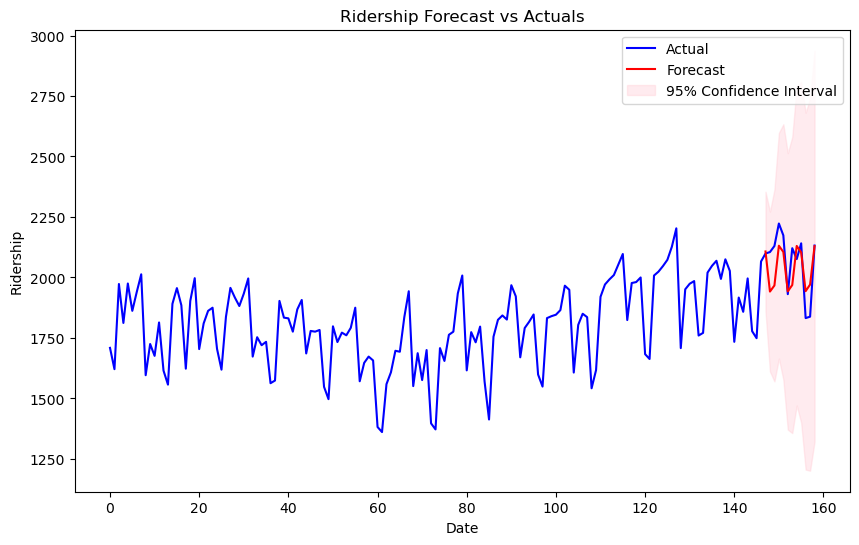

In [13]:
# Visualize the forecasted values vs. actial values 

# Plot the actual data
plt.figure(figsize=(10, 6))
plt.plot(df['Ridership'], label='Actual', color='blue')

# Plot the forecasted values
plt.plot(validation.index, forecasted_values, label='Forecast', color='red')

# Plot the confidence interval as a shaded area around the line
plt.fill_between(validation.index,
                 conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('Ridership Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.legend()
plt.show()

In [14]:
# Calculate MAE and RMSE and for quantitative evaluation and display
mae = mean_absolute_error(validation['Ridership'], forecasted_values)
rmse = np.sqrt(mean_squared_error(validation['Ridership'], forecasted_values))

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

Mean Absolute Error: 83.11331513864225
Root Mean Squared Error: 101.7224299659908


**ARIMA model**
- Mean Absolute Error: 83.11331513864225
- Root Mean Squared Error: 101.7224299659908

**SARIMA model**
- Mean Absolute Error: 66.44390526719188
- Root Mean Squared Error: 68.80673485805666

ARIMA model's MAE and RMSE are much greater than those of SARIMA model. Therefore, the SARIMA model, which accounts for both seasonality and non-seasonality components, seems to have a better predictive accuracy for your data than the ARIMA model, which does not account for seasonality.